<a href="https://colab.research.google.com/github/AshishGusain17/via_google_colab/blob/master/danceForms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn
import seaborn as sn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom
# from scipy.ndimage import imread

import keras
from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Training loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Training accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()


In [6]:
import h5py
data = h5py.File('/content/drive/My Drive/danceForms/train_150.h5', "r")
print(np.array(data))
XX = data["X"][:]
ZZ = data["Z"][:]

num = XX.shape[0] 
print(XX.shape,ZZ.shape,num)

['X' 'Z']
(364, 150, 150, 3) (364,) 364


In [11]:
# label_encoder= LabelEncoder()
# Y = label_encoder.fit_transform(Z)
Z = to_categorical(ZZ,8)
X = XX/255

x_train,x_test,y_train,y_test = train_test_split(X,Z,test_size=0.2,random_state=42)
print(x_train.shape,y_train.shape)

(291, 150, 150, 3) (291, 8)


In [0]:
augs_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=20,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

# augs_gen = ImageDataGenerator(vertical_flip=False) 
augs_gen.fit(x_train)

364


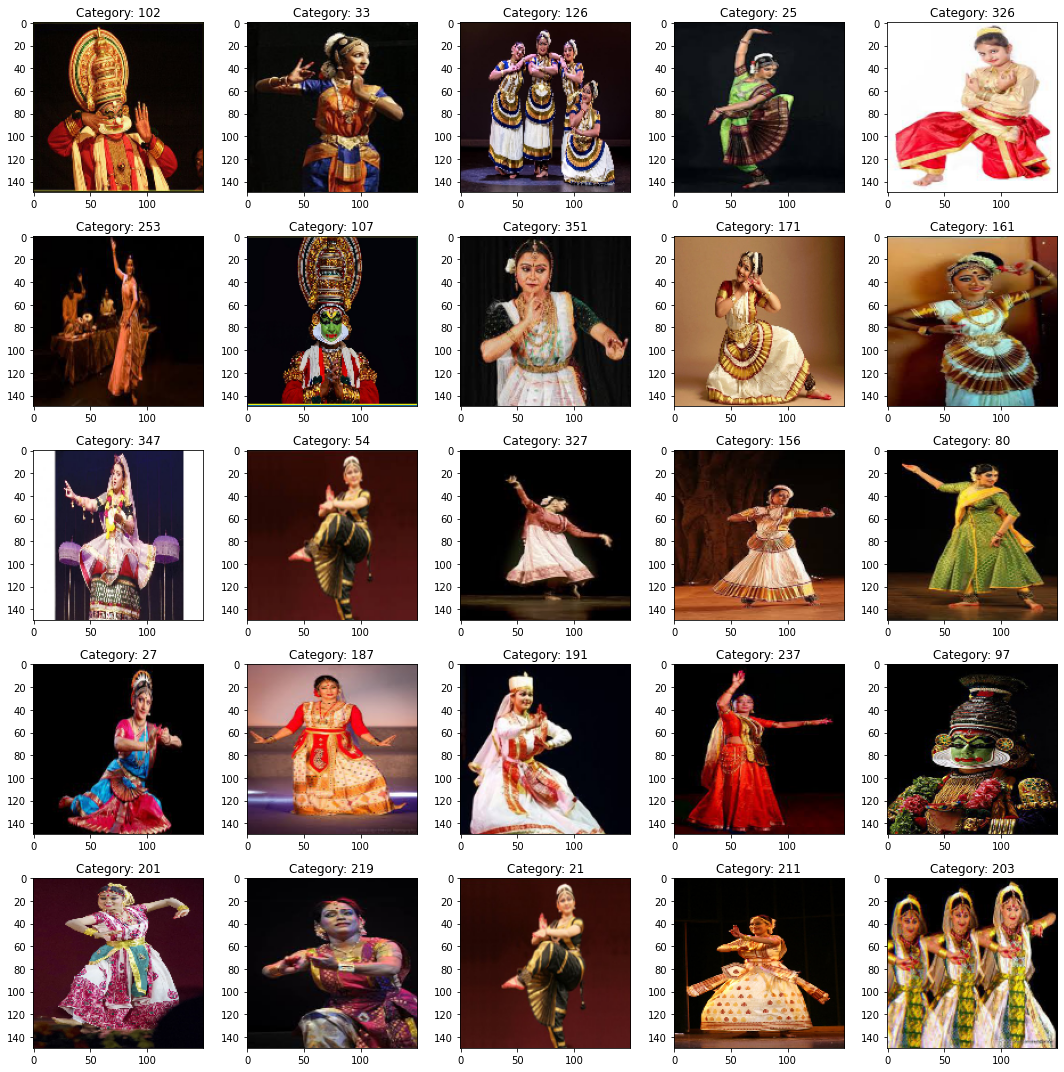

364


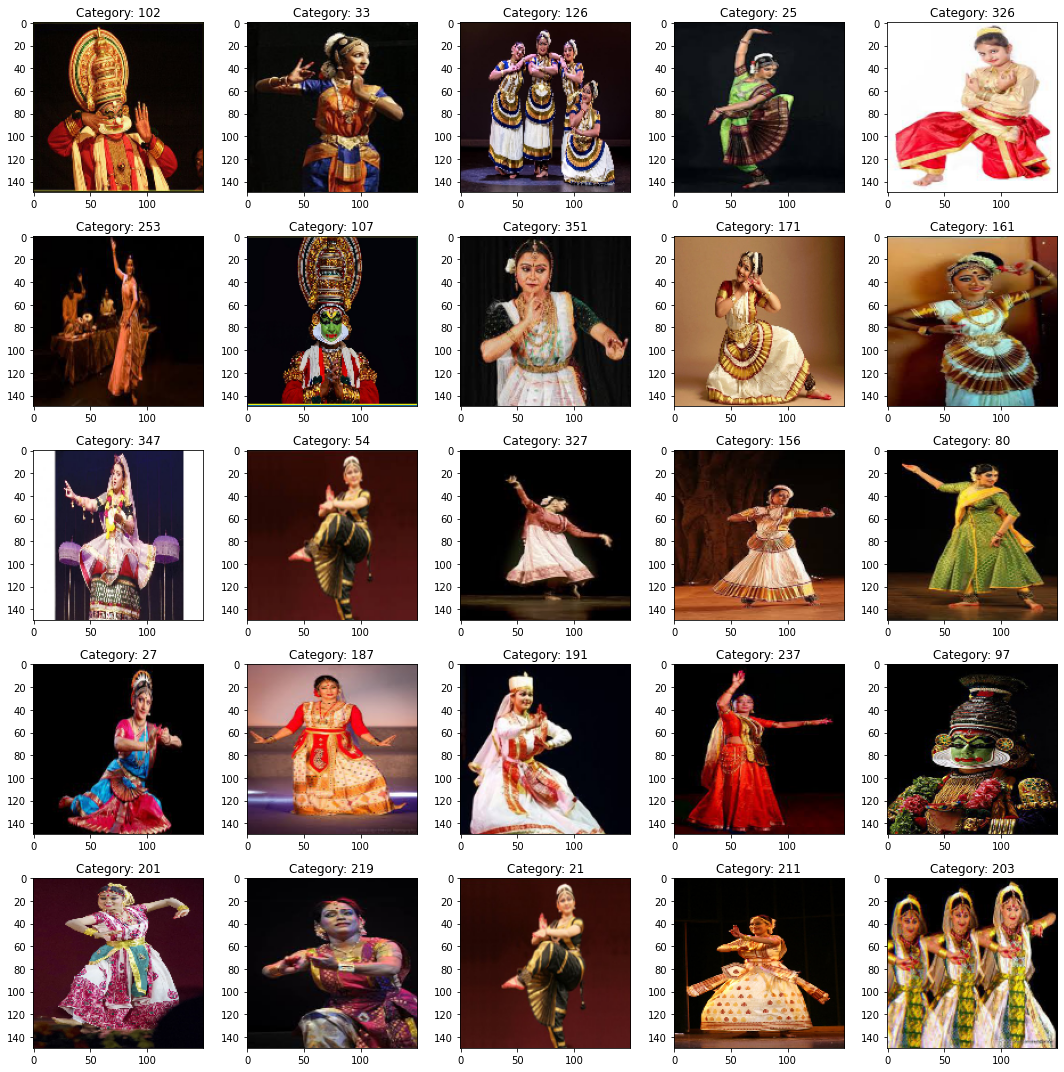

In [10]:
fig,ax=plt.subplots(5,5)
fig.set_size_inches(15,15)
print(len(Z))
for i in range(5):
    for j in range (5):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(XX[l])
        ax[i,j].set_title('Category: '+ str(l))
        
plt.tight_layout()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

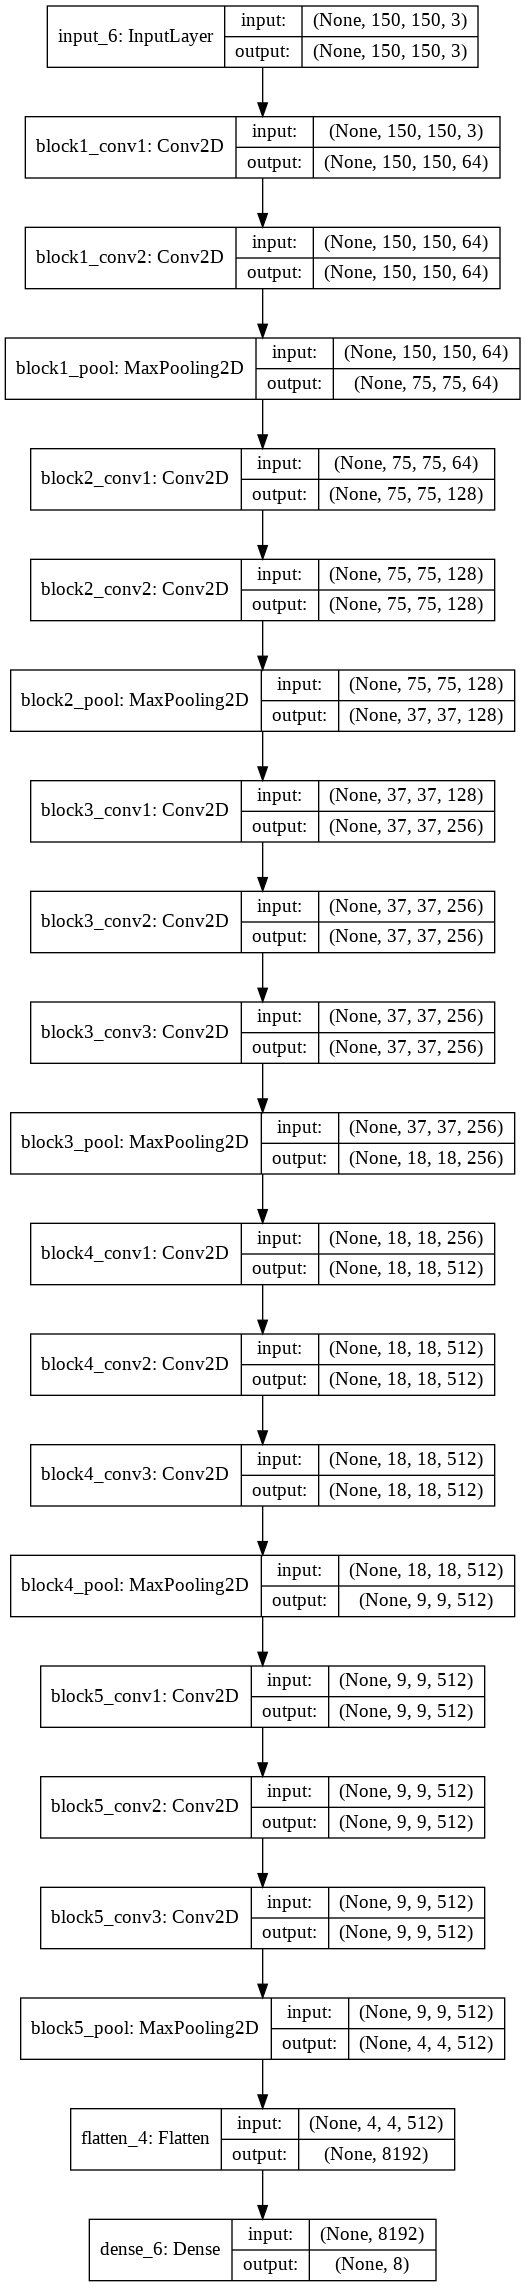

In [25]:
ct=0
imgsize=150
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')
base_model.summary()
# base_model.layers.pop()
# base_model.layers.pop()
# base_model.layers.pop()


model = Sequential()
for layer in base_model.layers:
  model.add(layer)

for layer in base_model.layers:
  ct=ct+1

for layer in base_model.layers:
  if ct>2:
    layer.trainable = False
  else:
    layer.trainable = True
  ct=ct-1
  print(layer,layer.trainable)



# model.add(GlobalAveragePooling2D())
# model.add(Dropout(0.3))
model.add(Flatten())

# model.add(regularizers.l2(0.01))

model.add(Dense(8,activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [26]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_acc',
    verbose=1,
    save_best_only=True,
    mode='max',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=50,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]
# callbacks = [earlystop,tensorboard,csvlogger,reduce]

/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:92: UserWarning: The TensorBoard callback `batch_size` argument (for histogram computation) is deprecated with TensorFlow 2.0. It will be ignored.
  warnings.warn('The TensorBoard callback `batch_size` argument '
/usr/local/lib/python3.6/dist-packages/keras/callbacks/tensorboard_v2.py:97: UserWarning: The TensorBoard callback does not support gradients display when using TensorFlow 2.0. The `write_grads` argument is ignored.
  warnings.warn('The TensorBoard callback does not support '


In [28]:

opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-3)

model.compile(
    loss='categorical_crossentropy',
    optimizer=opt1,
    metrics=['accuracy']
)


history = model.fit_generator(
    augs_gen.flow(x_train,y_train,batch_size=32),
    validation_data  = (x_test,y_test),
    # steps_per_epoch  = 100,
    epochs =15, 
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/15
10/10 [==============================] - 2s 158ms/step - loss: 0.8062 - accuracy: 0.7148 - val_loss: 1.0755 - val_accuracy: 0.7123
Epoch 2/15
 2/10 [=====>........................] - ETA: 0s - loss: 0.4628 - accuracy: 0.8594

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


10/10 [==============================] - 1s 130ms/step - loss: 0.5595 - accuracy: 0.8007 - val_loss: 1.2043 - val_accuracy: 0.6575
Epoch 3/15
10/10 [==============================] - 1s 143ms/step - loss: 0.3119 - accuracy: 0.9210 - val_loss: 1.4435 - val_accuracy: 0.6438
Epoch 4/15
10/10 [==============================] - 1s 134ms/step - loss: 0.3865 - accuracy: 0.8660 - val_loss: 1.7029 - val_accuracy: 0.6027

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/15
10/10 [==============================] - 1s 129ms/step - loss: 0.3086 - accuracy: 0.8935 - val_loss: 1.4927 - val_accuracy: 0.6575
Epoch 6/15
10/10 [==============================] - 1s 147ms/step - loss: 0.1773 - accuracy: 0.9416 - val_loss: 1.2916 - val_accuracy: 0.7123
Epoch 7/15
10/10 [==============================] - 1s 126ms/step - loss: 0.2109 - accuracy: 0.9244 - val_loss: 1.2876 - val_accuracy: 0.6986

Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e

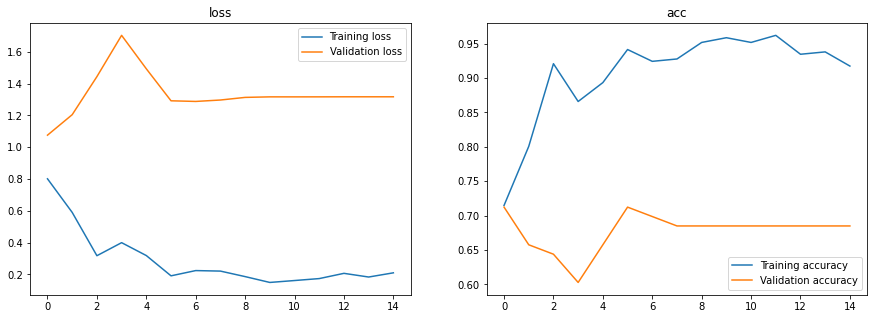

In [29]:
show_final_history(history)
# model.load_weights('./base.model')

# model_json = model.to_json()
# with open("model.json","w") as json_file:
#     json_file.write(model_json)
    
# model.save("model.h5")
# print("Weights Saved")

In [30]:
# use x 
a=model.evaluate(x_train,y_train)
b=model.evaluate(x_test,y_test)

print("Final loss of training data: {}".format(a[0]))
print("Accuracy of training data: {}".format(a[1]))
print("Final loss of test data: {}".format(b[0]))
print("Accuracy of test data: {}".format(b[1]))

ind=0

73/73 [==============================] - 0s 2ms/step
Final loss of training data: 0.051790599359593056
Accuracy of training data: 0.9896907210350037
Final loss of test data: 1.3167510073478907
Accuracy of test data: 0.6849315166473389


In [0]:
realdict = {'bharatanatyam' : 0,
        'kathak'        : 1,
        'kathakali'     : 2,
         'kuchipudi'    : 3,
         'manipuri'     : 4,
         'mohiniyattam' : 5,
         'odissi'       : 6,
         'sattriya'     : 7}

dictreverse =  {0 : 'bharatanatyam',
                 1 : 'kathak' ,
                 2 : 'kathakali',
                 3 : 'kuchipudi',
                 4 : 'manipuri',
                 5 : 'mohiniyattam',
                 6 : 'odissi',
                 7 : 'sattriya'}

['X' 'names']
(156, 150, 150, 3) (156,) 156
b'323.jpg'
sattriya


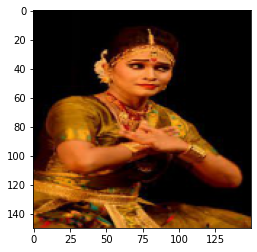

In [49]:
import h5py
data = h5py.File('/content/drive/My Drive/danceForms/test_150.h5', "r")
print(np.array(data))
XX = data["X"][:]
names = data["names"][:]
num = XX.shape[0] 
print(XX.shape,names.shape,num)


print(names[12])
plt.imshow(XX[12])

image = np.expand_dims(x_train[0], axis=0)
sd = model.predict(image)
arg = np.argmax(sd)
print(dictreverse[arg])

In [0]:
import csv

with open('answer2.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["Image", "target"])
    for ind in range(num):
        image = np.expand_dims(XX[ind], axis=0)
        sd = model.predict(image)
        arg = np.argmax(sd)
  
        writer.writerow([names[ind].decode('utf-8'), dictreverse[arg]])



